In [13]:
using LinearAlgebra
using FFTW
using Plots
plotlyjs()

Plots.PlotlyJSBackend()

In [14]:
struct out 
    input_fft :: Vector
    output_fft :: Vector
    adv :: Array
    diff :: Array
    T :: Array
    IC :: Array
end

In [15]:
# const domain = [2*pi, pi, 2]
# const dims = [128, 16, 128]
const Pr = 0.71
const nu = 1/180/Pr
const dt = 1e-4


const Nx = 16
const Nz = 32
const Ntheta = 129



const kx = 1
const ky = 0

0

In [16]:
x = LinRange(-pi, pi, Nx)
z = LinRange(0, 2, Nz)

const dx = x[2] - x[1]
const dz = z[2] - z[1]

xx = x' .+ z.*0
zz = x' .* 0 .+ z

u = zz .* (2 .- zz)
v = zz .* 0
w = zz .* 0;

In [30]:
T = zeros(Float64, (Nz, Nx))
T[2, :] = sin.(kx .* x)

T[1, :] .= 0
T[end, :] .= 0

# input = [fft(T[:, k], 1)[kx+1] for k in range(1, Nz)]
input = fft(T, 2)

32×16 Matrix{ComplexF64}:
          0.0+0.0im     0.0+0.0im      …     0.0+0.0im
 -7.77156e-16+0.0im  -1.498+7.53098im     -1.498-7.53098im
          0.0+0.0im     0.0+0.0im            0.0+0.0im
          0.0+0.0im     0.0+0.0im            0.0+0.0im
          0.0+0.0im     0.0+0.0im            0.0+0.0im
          0.0+0.0im     0.0+0.0im      …     0.0+0.0im
          0.0+0.0im     0.0+0.0im            0.0+0.0im
          0.0+0.0im     0.0+0.0im            0.0+0.0im
          0.0+0.0im     0.0+0.0im            0.0+0.0im
          0.0+0.0im     0.0+0.0im            0.0+0.0im
             ⋮                         ⋱        ⋮
          0.0+0.0im     0.0+0.0im            0.0+0.0im
          0.0+0.0im     0.0+0.0im            0.0+0.0im
          0.0+0.0im     0.0+0.0im      …     0.0+0.0im
          0.0+0.0im     0.0+0.0im            0.0+0.0im
          0.0+0.0im     0.0+0.0im            0.0+0.0im
          0.0+0.0im     0.0+0.0im            0.0+0.0im
          0.0+0.0im     0.0+0.0im       

In [18]:
T = zeros(Float64, (Nx, Nz))
T[2, :] = sin.(kx .* x)

T[1, :] .= 0
T[end, :] .= 0

# input = [fft(T[:, k], 1)[kx+1] for k in range(1, Nz)]
input = fft(T', 2)[kx+1, :]


adv = zeros(Float64, (Nx, Nz))
adv[:, 2:end-1] .= u[:, 2:end-1].*(circshift(T[:, 2:end-1],(1, 0)) .- circshift(T[:, 2:end-1],(-1, 0)))./dx./2

diff = zeros(Float64, (Nx, Nz))
diff[:, 2:end-1] .= nu .*( circshift(T[:, 2:end-1],(1,0)) .- 2 .*T[:, 2:end-1] .+ circshift(T[:, 2:end-1],(-1,0)))./dx./dx .+ 
nu .*(T[:, 3:end] .- 2 .*T[:, 2:end-1] .+ T[:, 1:end-2] ) ./dz./dz

T_out = zeros(Float64, (Nx, Nz))
T_out .= T .- dt .* adv .+ dt .* diff

# output = [fft(RHS[:, k], 1)[kx+1] for k in range(1, Nz)]
output = fft(T_out', 2)[kx+1, :]

DimensionMismatch: DimensionMismatch: arrays could not be broadcast to a common size; got a dimension with lengths 32 and 16

In [7]:
theta_ic = zeros(Float64, (Nx, Nz, Ntheta))
[theta_ic[:, k, k] = sin.(kx .* x) for k in range(1, Nz)]


function solver(u, v, w, T)

    T[:, 1] .= 0
    T[:, end] .= 0

    # input = [fft(T[:, k], 1)[kx+1] for k in range(1, Nz)]
    input = fft(T', 2)[kx+1, :]


    adv = zeros(Float64, (Nx, Nz))
    adv[:, 2:end-1] .= u[:, 2:end-1].*(circshift(T[:, 2:end-1],[1, 0]) .- circshift(T[:, 2:end-1],[-1, 0]))./dx./2

    diff = zeros(Float64, (Nx, Nz))
    diff[:, 2:end-1] .= nu .*( circshift(T[:, 2:end-1],[1,0]) .- 2 .*T[:, 2:end-1] .+ circshift(T[:, 2:end-1],[-1,0]))./dx./dx .+ 
    nu .*(T[:, 3:end] .- 2 .*T[:, 2:end-1] .+ T[:, 1:end-2] ) ./dz./dz

    T_out = zeros(Float64, (Nx, Nz))
    T_out .= T .- dt .* adv .+ dt .* diff

    # output = [fft(RHS[:, k], 1)[kx+1] for k in range(1, Nz)]
    output = fft(T_out', 2)[kx+1, :]

    return input, output
end



result = zeros(Float64, (Nx, Nz, Ntheta))
A = Array{ComplexF64, 2}(undef, Nz, Nz)
B = Array{ComplexF64, 2}(undef, Nz, Nz)

for k in range(1, Nz)
    A[:, k], B[:, k] = solver(u, v, w, theta_ic[:, :, k])
    # result[:, :, k] .= S.T .* 1
    # A[:, k] .= S.input_fft .* 1
    # B[:, k] .= S.output_fft .* 1
end


DimensionMismatch: DimensionMismatch: tried to assign 16-element array to 32×1 destination

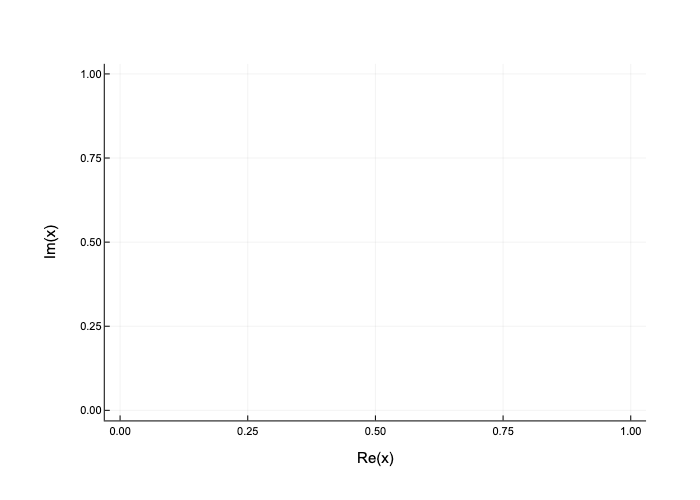

In [9]:
F = eigen(B,A)
omega = 1im.*log.(F.values)./dt
scatter(omega)

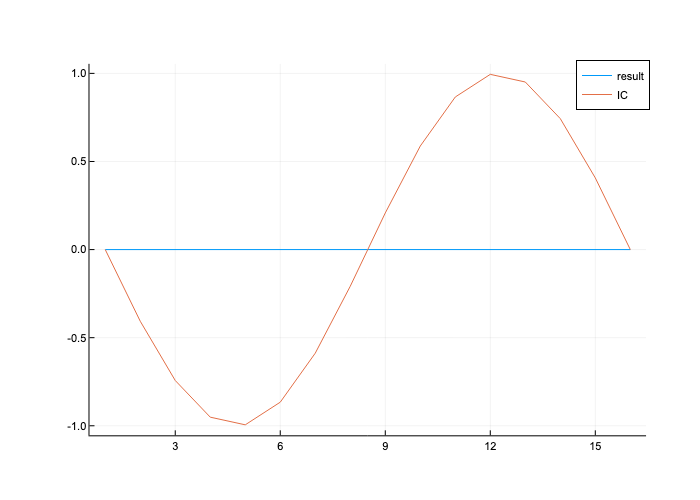

In [10]:
plot(result[:, 3, 3], label="result")
plot!(theta_ic[:, 3, 3], label="IC")

In [11]:
kk = 64
S = solver(u, v, w, theta_ic[:, :, kk])
plot(S.adv[:, kk])

ErrorException: type Tuple has no field adv

In [12]:
kk = 64
S = solver(u, v, w, theta_ic[:, :, kk])
plot(S.diff[:, kk])

ErrorException: type Tuple has no field diff